## Title : TMDB Box Office Prediction

#### Project Team 2:
- Aditi Hegde

- Siddhartha Jakkamreddy (Sid)

- Venky Nagapudi

## 1. Introduction


### Objective: 

>**Predict the worldwide box office revenue of the movie.**

### Background: 

This is an ongoing Kaggle competetion. Movies made an estimated 41.7 billion dollars in 2018, the film industry is more popular than ever. We are trying to evaluate what movies make the most money at the box office? Looking at various data points and modeling based on features like - How much does a director matter? Or the budget? Does genre matter?

### Dataset: 

The data consists of 7,398 past films from The Movie Database. The data is split into 3000 movies in train file and the rest 4398 movies in test file. The dataset is structured and are provided as .csv files with 23 columns. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. 

The dataset contains various types of columns. 
* numerical columns - budget, popuarity, runtime, revenue
* Categorical columns - Language, Genre, Status
* DateTime - Release Date
* String - Overview, Tagline, Title
* The dataset consists of list of nested JSON objects for columns like Keywords, Cast, Crew which are elaborate with lot of details.


### Packages used 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")
from ast import literal_eval
from wordcloud import WordCloud
import itertools
from collections import Counter
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean ,stdev
from sklearn.model_selection import KFold
import xgboost as xgb
import os
from xgboost import XGBClassifier

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Libraries

In [2]:
def get_dictionary(s):
    try:
        d = literal_eval(s)
    except:
        d = {}
    return d

## 2. Exploratory Data Analysis

EDA is an important step as we learn about the data and its main characteristics. We look at each column data and perform some analysis to check what transformations are required and if the column can be included in our set of features.

 

### Initial Training Data before Transformations

Let's get basic idea about the data. 

In [117]:
#Load test and train set.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

>Train data has 3000 entries and 23 columns. There are few numerical columns and a lot of columns that are objects.

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

>Test data consists of 4398 entries and the data columns are similar to train set.

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

>A quick sneak peak into the train set. We do observe there are NaN values across multiple columns. The columns with object type and mainly key value pairs. Thus each column contains more than one feature of data. We are going to denormalise each and pick out relevant features.

In [6]:
train.head(15)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,2/16/96,100.0,"[{'

>Summary of numeric values show that there are few movies with 0 budget that looks incorrect. There are also some runtime with value 0. 

In [7]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


### Analysis of Key variables 

#### 1. Budget & Revenue of movie

Looking at the distribution of Budget and Revenue columns. Both revenue and budget are skewed. 

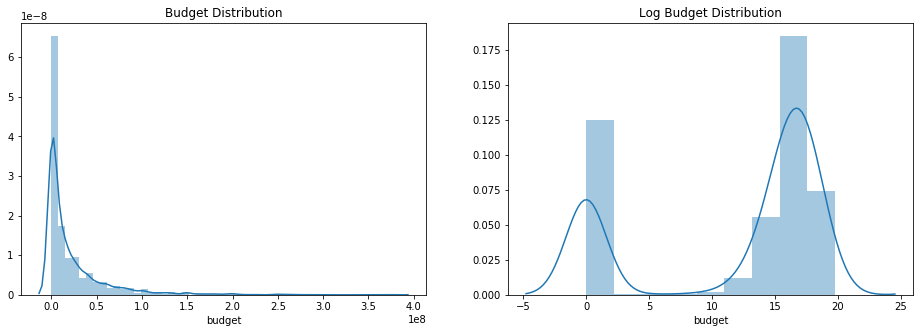

In [8]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.distplot((train['budget'])).set_title("Budget Distribution")

plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['budget'])).set_title("Log Budget Distribution")

plt.show()

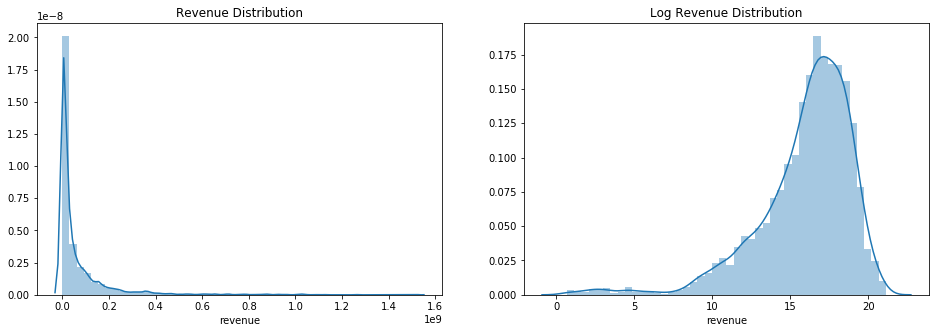

In [9]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.distplot((train['revenue'])).set_title("Revenue Distribution")

plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['revenue'])).set_title("Log Revenue Distribution")

plt.show()

#### Budget vs Revenue

>Lets add log columns for budget and revenue

In [10]:
train['budget_log'] = np.log1p(train['budget'])
train['revenue_log'] = np.log1p(train['revenue'])

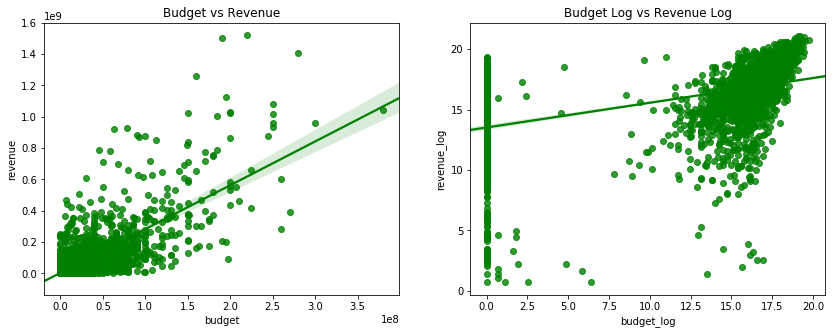

In [11]:
fig, axes = plt.subplots(figsize=(14,5),nrows=1, ncols=2)
sns.regplot(x="budget", y="revenue", data=train, color="g",ax=axes[0]).set_title("Budget vs Revenue")
sns.regplot(x="budget_log", y="revenue_log", data=train, color="g",ax=axes[1]).set_title("Budget Log vs Revenue Log")
plt.show()

#### 2. Cast

>Cast column is an example of object type in the data. Every cast has detailed information about differnt actors playing the role in the movie. Based on the size of the movie, the number of cast member can vary significantly.

In [123]:
for i,j in enumerate(train['cast'][:1]):
    print(i,j)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

#### 3. Crew

>Crew consists people on the movie set other than the cast. The column consists of multiple jobs. The below graph is a Wordcloud of different personnals but not directors based on frequency.

In [13]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in get_dictionary(x)
                                                        if i['job'] != 'Director'] if x != {}
                                               else []).values)


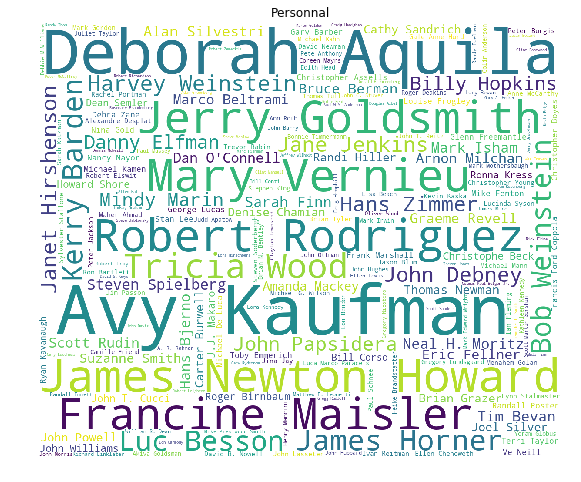

In [14]:
plt.figure(figsize = (12, 8))
text=Counter([i for j in list_of_crew_names for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=True,
                      width=1200, height=1000).generate_from_frequencies(text)
plt.imshow(wordcloud)
plt.title('Personnal')
plt.axis("off")
plt.show()

#### 4. Director

>Directors are key for success of the movies. Let's analyse directors of the movies. The intuition is good directors are a part of great movies that result in generating a lot of revenue.

In [15]:
list_of_directors = list(train['crew'].apply(lambda x: [i['name'] for i in get_dictionary(x) 
                                                   if i['job'] == 'Director']).values)


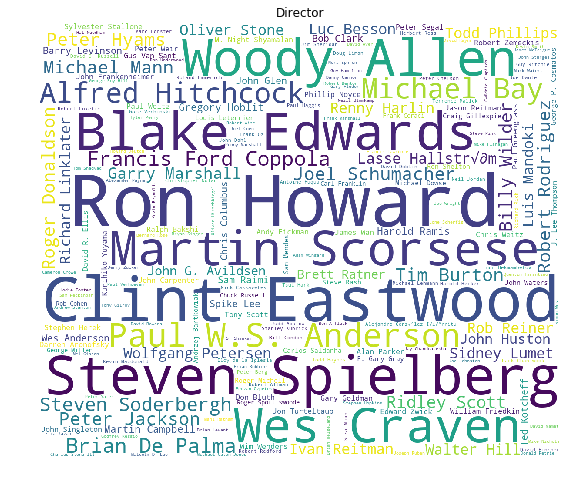

In [16]:
plt.figure(figsize = (12, 8))
text=Counter([i for j in list_of_directors for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=True,
                      width=1200, height=1000).generate_from_frequencies(text)
plt.imshow(wordcloud)
plt.title('Director')
plt.axis("off")
plt.show()

>Our intuition is right. From the graph below it shows that the top directors are contributing towards larger chunk of revenue. Clearly a Peter Jackson is likely to earn higher revenues for his movie than other directors. So it makes sense to include the Director as a key independent variable for modeling

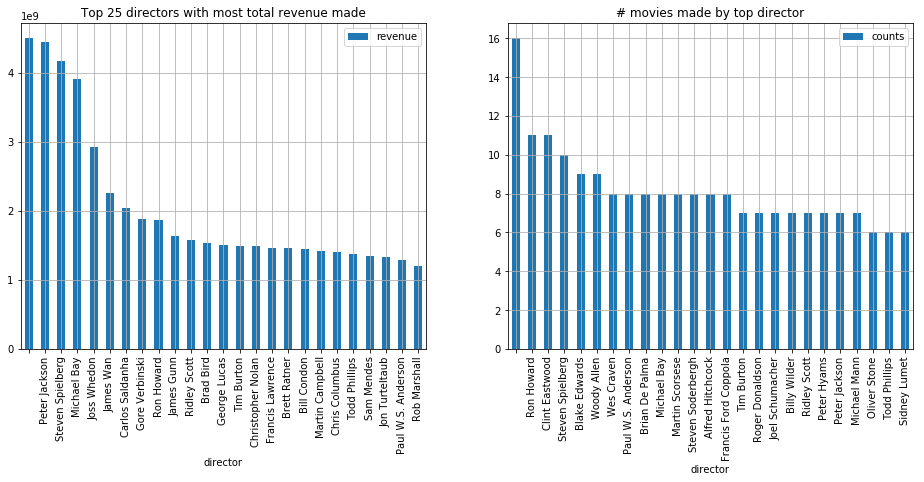

In [17]:
#Checking our intuition
train['director'] = train['crew'].apply(lambda x: [i['name'] for i in get_dictionary(x) 
                                                   if i['job'] == 'Director']).map(lambda x: ','.join(map(str, x)))
director_table = train[['director', 'revenue']]
top_directors = director_table.groupby("director").revenue.sum().reset_index().sort_values("revenue", ascending = False).head(25)

#"Top 25 directors with most total revenue made"
top_directors.set_index('director', inplace=True)
fig, axes = plt.subplots(figsize=(16,6),nrows=1, ncols=2)
top_directors.head(25).plot.bar(ax=axes[0], grid=True, title="Top 25 directors with most total revenue made")

#No of movies made by top director
director_freq = train[['director']]
df = director_freq.groupby(['director']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(25)
df.set_index('director', inplace=True)
#print (df)
df.head(25).plot.bar(ax=axes[1], grid=True, title="# movies made by top director")

#### 5. Genre

>There are multiple genres among the movies present in the dataset. Each movie can be a combination of different genres as well.  Let us look at the popular genres.

In [18]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(get_dictionary(x)) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [19]:
list_of_genres = list(train['genres'].map(lambda x: sorted([d['name'] 
                                                        for d in get_dictionary(x)])
                                     ))

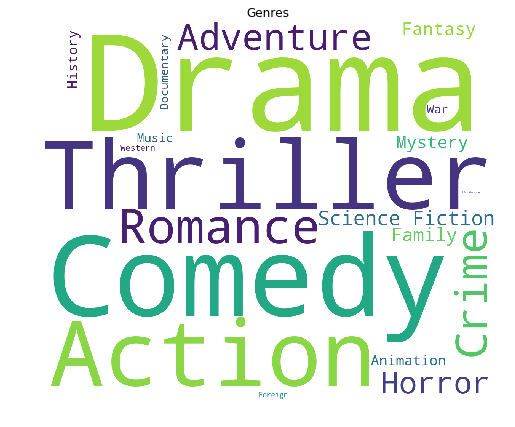

In [116]:
plt.figure(figsize = (12, 7))
text=Counter([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=True,
                      width=1200, height=1000).generate_from_frequencies(text)
plt.imshow(wordcloud)
plt.title('Genres')
plt.axis("off")
plt.show()

#### 6. Characters/Actors

>Similar to directors, the cast of the movie can drive the revenue it generates. Below is the analysis of the top actors among the train data.

In [21]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in get_dictionary(x)] if x != {} else []).values)

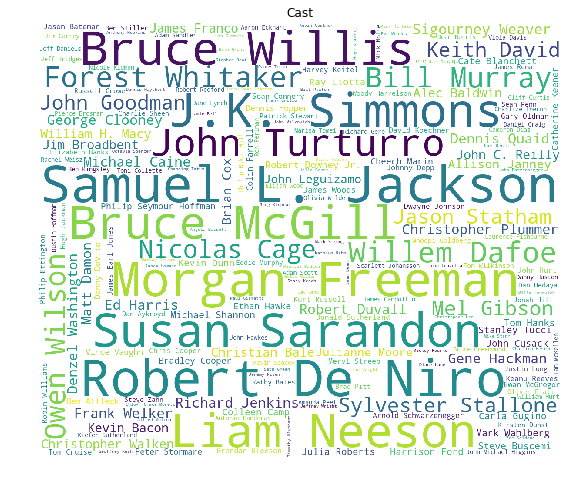

In [22]:
plt.figure(figsize = (12, 8))
text=Counter([i for j in list_of_cast_names for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=True,
                      width=1200, height=1000).generate_from_frequencies(text)
plt.imshow(wordcloud)
plt.title('Cast')
plt.axis("off")
plt.show()

#### 7. Release date

Release date of the movie is an important factor as well. The time of the release of the movie like in holiday season can drive more revenue.

Looking at the below graph , it is clear that more movies are released in the third quarter, mostly thanks to September releases. The last 4 months contribute more towards movie releases than all other months. So it is likely that these movies should do well.

In [23]:
train['release'] = pd.to_datetime(train['release_date'])

In [24]:
train['release_quarter'] = pd.to_datetime(train.release).dt.quarter
train['release_yrquarter'] = pd.PeriodIndex(pd.to_datetime(train.release), freq = 'Q')
train['release_month'] = pd.to_datetime(train.release).dt.month

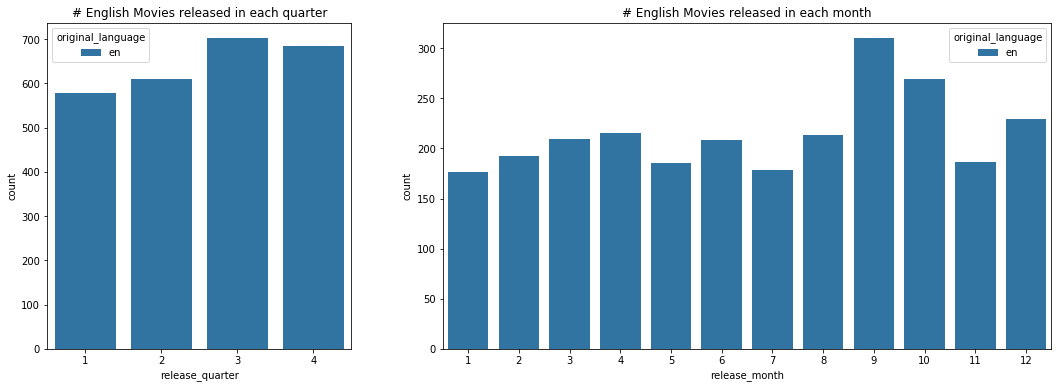

In [25]:
fig, axes = plt.subplots(figsize=(18,6),nrows=1, ncols=2,gridspec_kw = {'width_ratios':[1, 2]})

sns.countplot(train.loc[train['original_language'] == 'en'].release_quarter, 
              hue = train.loc[train['original_language'] == 'en'].original_language, ax=axes[0]).set_title(
    "# English Movies released in each quarter")

sns.countplot(train.loc[train['original_language'] == 'en'].release_month, 
              hue = train.loc[train['original_language'] == 'en'].original_language, ax=axes[1]).set_title(
    "# English Movies released in each month")
plt.show()

 But what is the distribution of revenues to months?

In [26]:
rev_by_month = train[['release_month', 'revenue']]
rev_by_month_df = rev_by_month.groupby("release_month").revenue.sum().reset_index()
rev_by_month_df.set_index('release_month', inplace=True)

avg_rev_by_month_df = rev_by_month.groupby("release_month").revenue.mean().reset_index()
avg_rev_by_month_df.set_index('release_month', inplace=True)
#.sort_values("revenue", ascending = False)

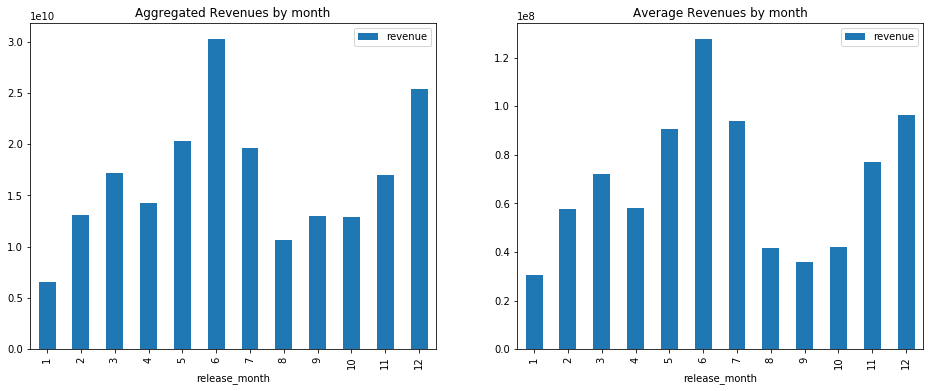

In [27]:
fig, axes = plt.subplots(figsize=(16,6),nrows=1, ncols=2)
rev_by_month_df.plot.bar(ax=axes[0],title="Aggregated Revenues by month")

avg_rev_by_month_df.plot.bar(ax=axes[1],title="Average Revenues by month")
#rev_by_month_df.head(12)

plt.show()

>Even though fewer movies are released in June, it is clear that June movies make more revenue. December movies are just behind June. Let's look at average revenues for monthly releases

>Again, this clearly shows a strong dependency between average revenue and month of release. We need to definitely factor in the month of release into the model

#### 8. Language

>The dataset contains movies across multiple languages. The English movies are predominant in the dataset and also corresponds to majority of revenue collected.

In [28]:
np.unique(train['original_language'],return_counts=True)
train['lang_catg'] = train['original_language'].astype('category').cat.codes

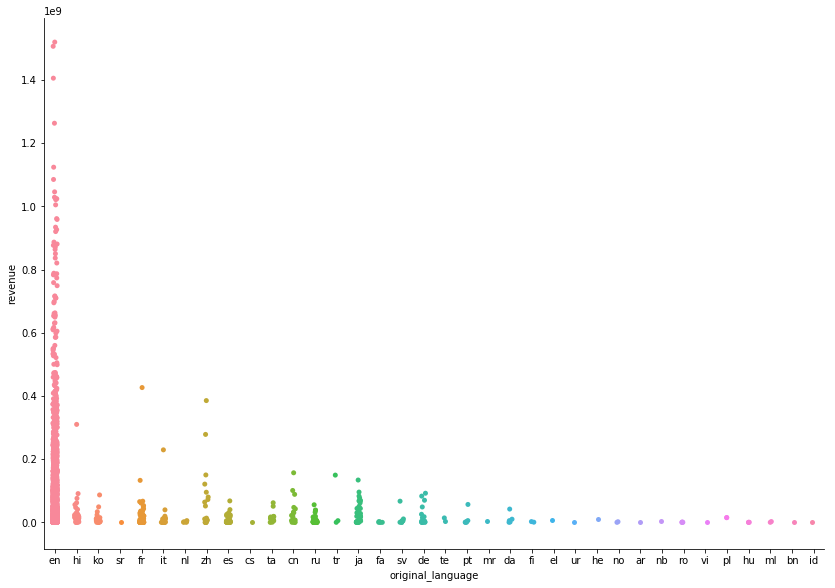

In [29]:
sns.catplot(x="original_language", y="revenue", data=train,height=8.27, aspect=11.7/8.27);

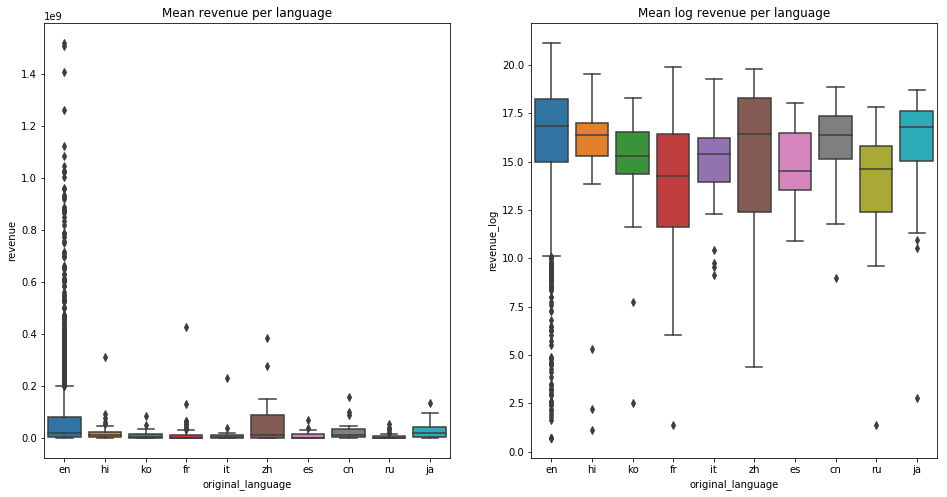

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', 
            data=train.loc[train['original_language'].isin(train['original_language'
                                                                ].value_counts().head(10).index)]);
plt.title('Mean revenue per language');

plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='revenue_log', 
            data=train.loc[train['original_language'].isin(train['original_language'
                                                                ].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

#### 9. Series/Non Series

>Whether a movie is part of series or not is an important factor for the revenue collection. From the below graph, it is eveident that the highest grossing movie has been part of the Series and the average collection is higher than the other category

In [31]:
train['Series'] = (train['belongs_to_collection'].apply(lambda x:1 if str(x) != 'nan' else 0))


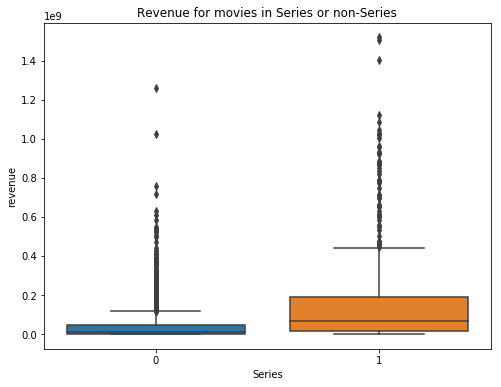

In [32]:
plt.figure(figsize = (8, 6))
sns.boxplot(x="Series", y="revenue", data=train).set_title("Revenue for movies in Series or non-Series");
plt.show()

#### 10. Popularity

>The popularity of the movie before the release is a big factor for revenue. 
>The revenue column consists of many outliers. The scale is not described of how the popularity is being measured.

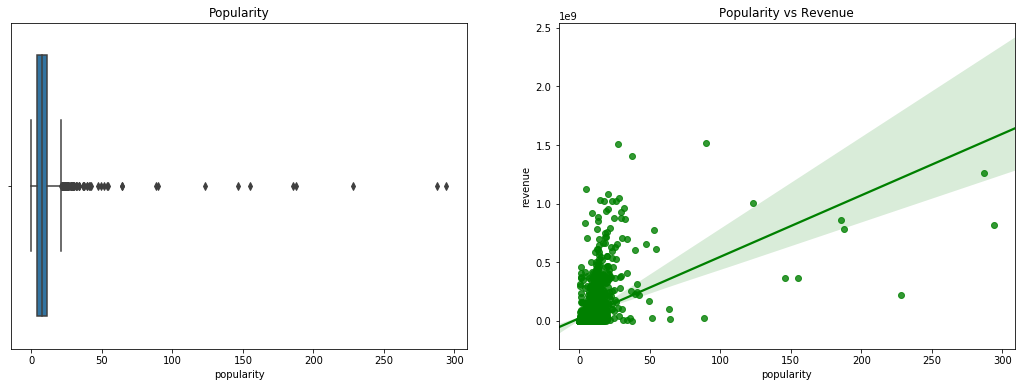

In [33]:
plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="popularity", data=train).set_title("Popularity");

plt.subplot(1, 2, 2)
sns.regplot(x="popularity", y="revenue", data=train, color="g").set_title("Popularity vs Revenue")
plt.show()

#### 11. Keywords

>Keywords in the movie talk about the storyline. Lets look into the popular storylines below

In [34]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in get_dictionary(x)] if x != {} else []).values)

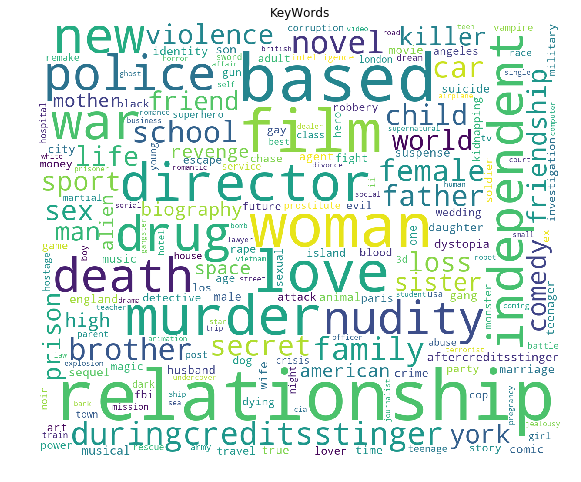

In [35]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('KeyWords')
plt.axis("off")
plt.show()

#### 12. Production Companies

>Production Companies are directly related to budget of the movie.

In [36]:
list_of_production = list(train['production_companies'].apply(lambda x: [i['name'] for i in get_dictionary(x)]
                                                              if x != {} else []).values)


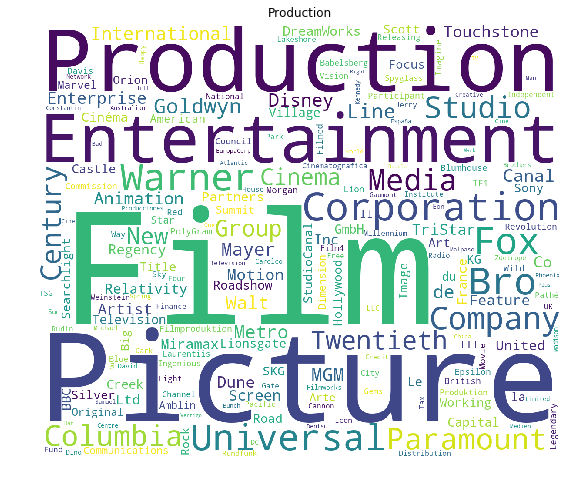

In [37]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_production for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Production')
plt.axis("off")
plt.show()

#### 13. Production Countries

>Some of these movies seem to be produced with a large budget in many countries. The more the number of countries associated with a movie, the more likely that it might have a large budget. And as we saw before, a big budget is a likely indicator that the movie will succeed. We believe that the production countries therefore are a proxy for large budget.


In [38]:
list_of_production_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in get_dictionary(x)]
                                                              if x != {} else []).values)

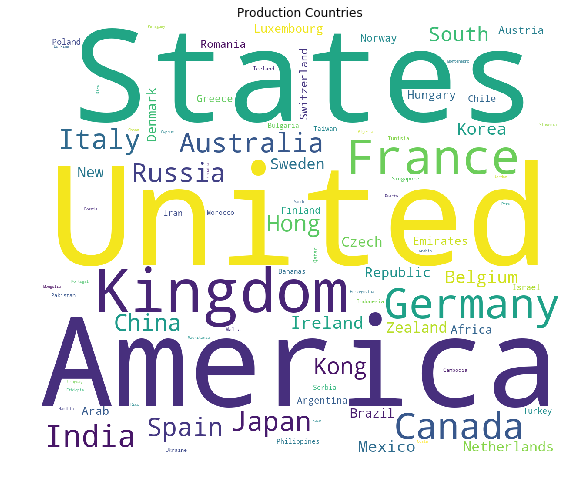

In [39]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_production_countries for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Production Countries')
plt.axis("off")
plt.show()


>But there is probably still some value in figuring out if a movie was completely based outside of USA or New Zealand or similar. These movies might not have the highest revenues. Let's see whether the lowest revenue movies were made outside of these countries.

In [40]:
train['prod_countries'] = train['production_countries'].apply(lambda x: [d['name'] for d in get_dictionary(x)])\
                                                       .map(lambda x: ','.join(map(str, x)))


In [41]:
rev_by_country = train[['prod_countries', 'revenue']]
#Tope 10
avg_rev_by_country_df = rev_by_country.groupby("prod_countries").revenue.mean().reset_index().sort_values("revenue",
                                                                                                          ascending = False)
avg_rev_by_country_df.set_index('prod_countries', inplace=True)

#Low 10
avg_rev_by_country_df = rev_by_country.groupby("prod_countries").revenue.mean().reset_index().sort_values("revenue",
                                                                                                          ascending = True)

avg_rev_by_country_df.set_index('prod_countries', inplace=True)


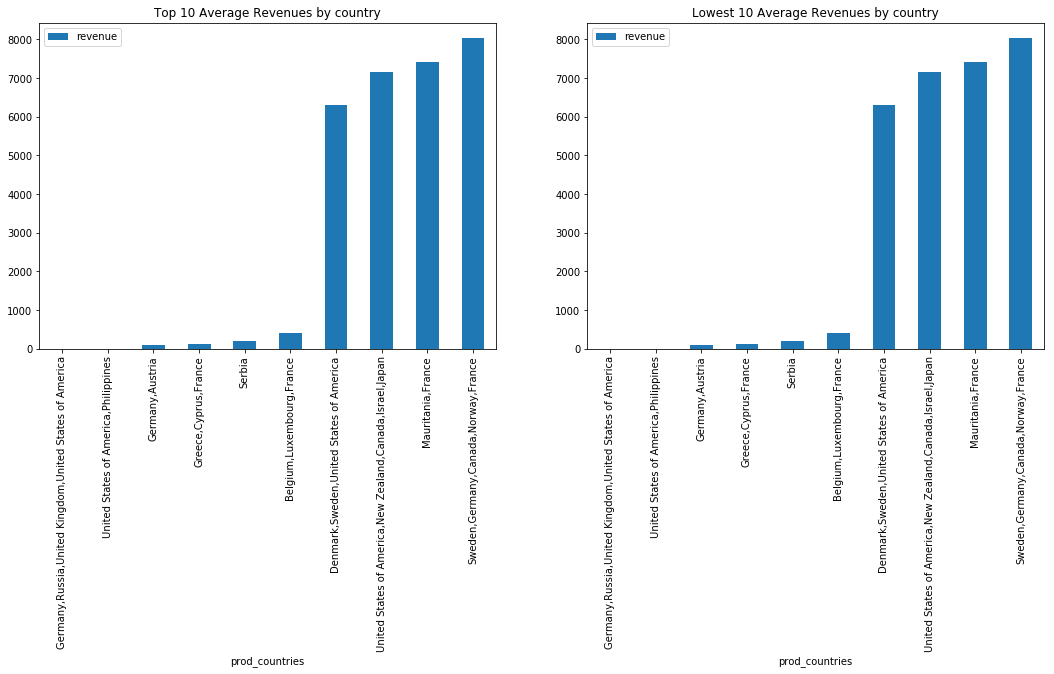

In [42]:
fig, axes = plt.subplots(figsize=(18,6),nrows=1, ncols=2)
avg_rev_by_country_df.head(10).plot.bar(ax=axes[0],title="Top 10 Average Revenues by country")

avg_rev_by_country_df.head(10).plot.bar(ax=axes[1],title="Lowest 10 Average Revenues by country")

>Nothing much is conclusive here. Perhaps we can drop the production country for now as a variable of interest.

#### 14. Run Time

>Plotting the run length of movies, we see that the data is almost normal, with a mean of around 100 minutes. Do movies that have higher revenues also run longer?

>The runtime also contains some NA values. Lets try to fix them by coercing them to mean value.

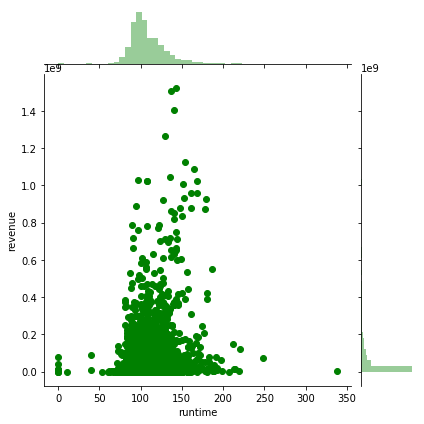

In [43]:
train['runtime'] = pd.to_numeric(train['runtime'], errors='coerce')
train["runtime"] = train["runtime"].fillna(value=train["runtime"].mean())
sns.jointplot(x="runtime", y="revenue", data=train, color="g")
plt.show()

>Ignoring other factors, the highest grossing movies seem to be in the 150 minute runtime, while the lowest grossing ones are in the far end of the runtime spectrum. If a movie is too long or too short, it impacts the revenues negatively. So this is a significant factor

#### Correlation between variables

- We build out a correlation matrix to see how the different variables are correlated with each other.

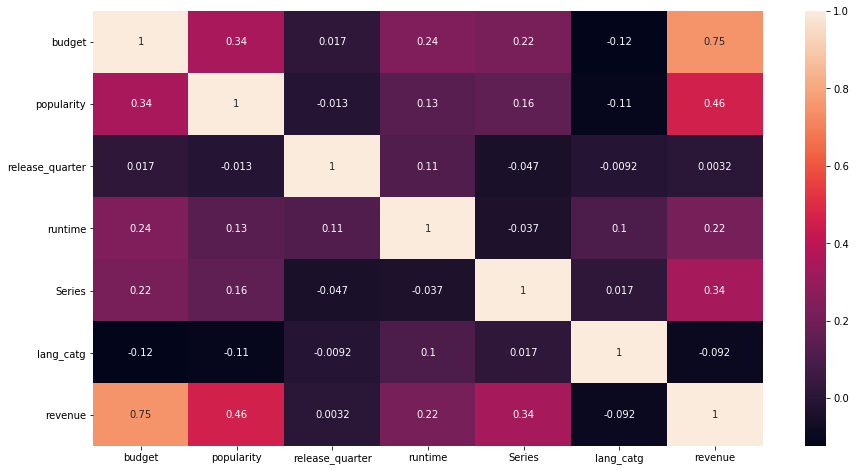

In [44]:
train_corr = train[['budget', 'popularity', 'release_quarter', 'runtime', 'Series','lang_catg', 'revenue']]
f,ax = plt.subplots(figsize=(15, 8))
sns.heatmap(train_corr.corr(), annot=True)
plt.show()

## 3. Baseline Model - Linear Regression

>The baseline regression model with the numeric columns of the train data set.

In [45]:
train_X_base = train[['budget_log', 'popularity', 'release_quarter', 'runtime', 'Series','lang_catg']]
train_Y_base = train['revenue_log']

_x_train, _x_dev, _y_train, _y_dev = train_test_split(train_X_base, train_Y_base, test_size=0.33, random_state=42)
LR_model = LinearRegression()
LR_model.fit(_x_train, _y_train)

_rms = sqrt(mean_squared_error(_y_dev, LR_model.predict(_x_dev)))
print (_rms)

2.3448744706559284


#### Storing Model results

In [86]:
model_result = pd.DataFrame(columns=['Model Name', 'RMSE'])
model_result.loc[len(model_result)]=["Baseline Regression",_rms]

## 4. Feature Engineering

Based on the above analysis, we can come to the conclusion of using below set of features in the model

>Target: Revenue (log)

Inputs:

1. Budget : Log of Budget 
2. Popularity
3. Runtime : Length of the movie, coerced with mean for NA values 
4. Release Date Columns: Year, Month, Week and Day of the release date
5. Genres: COnverting genres into an indicator variable. Each genre has its own column. 
6. Language Category: Language represented in form of codes
7. Series : Movie part of series or not
8. Cast size: Number of people casted in the movie
9. Homepage: Indicator for presence of Homepage website
10. Crew count : Number of crew members based on gender
11. Poster: Indicator for poster
12. Production Countries count : No of countries in production
13. Production company count: No of production companies 
14. Top Directors: List of 25 Top Directors based on revenue
15. Top Actors: List of 25 Top Actors.


### 4.1. Fix Missing Dataset

>Budget is our key column in determining the revenue. Both test and train set have some of the values as 0. Looking at the information on the movies, we try to add the missing data information.

In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### 4.1.1 Missing budget values - Train

In [54]:
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

#### 4.1.2 Missing budget values - Test

In [55]:
#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30



### 4.2 Transormation of the data

Functions to add transformed columns to the data. These transformations needs to be done both on test and train data. Once the transformations are done, we will drop the columns not needed for the model

In [56]:
def top_dir_list():
    train['director'] = train['crew'].apply(lambda x: [i['name'] for i in get_dictionary(x) 
                                                   if i['job'] == 'Director']).map(lambda x: ','.join(map(str, x)))
    
    director_table = train[['director', 'revenue']]
    top_directors = director_table.groupby("director").revenue.sum().reset_index().sort_values("revenue",
                                                                                               ascending = False).head(25)
    
    top_directors.set_index('director', inplace=True)
    top_director_list = []
    for d in top_directors.index :
        if (d != ""):
            top_director_list.append(d)
    return top_director_list

In [57]:
def top_director(data):
#Adding Top Directors
    data['director'] = data['crew'].apply(lambda x: [i['name'] for i in get_dictionary(x) 
                                                   if i['job'] == 'Director']).map(lambda x: ','.join(map(str, x)))

    dir_list_enum = data.director.str.get_dummies(sep=',')
    
    #Use this in the model
    top_dir_list_enum = dir_list_enum[top_dir_list()]
    return top_dir_list_enum



In [58]:
def top_actor(data):
    #Use at least the top 50 actors who created the most revenue for the model
    top_actor_list = []
    actors= []
    
    #List from https://www.businessinsider.com/actors-with-highest-box-office-2016-9#36-orlando-bloom-2988-billion-15
    top_actor_list = ["Mark Hamill","Adam Sandler","Ben Stiller","Forest Whitaker","Elizabeth Banks","Carrie Fisher",
                      "Ralph Fiennes","Mark Ruffalo","Julia Roberts","Owen Wilson","Mark Wahlberg","Helena Bonham Carter",
                      "Simon Pegg","Steve Carell","Orlando Bloom","Liam Neeson","Cameron Diaz","Chris Hemsworth","Chris Evans",
                      "Chris Pratt","Matt Damon","Will Smith","Emma Watson","Bruce Willis","Robert DeNiro","Cate Blanchett",
                      "Woody Harrelson","Robin Williams","Stellan Skarsgard","Zoe Saldana","Dwayne Johnson","Gary Oldman",
                      "Michael Caine","Vin Diesel","Don Cheadle","Bradley Cooper","Ian McKellan","Johnny Depp","Idris Elba",
                      "Stanley Tucci","Eddie Murphy","Tom Cruise","Anthony Daniels","Andy Serkis","Scarlett Johansson",
                      "Morgan Freeman","Tom Hanks","Robert Downey","Harrison Ford","Samuel L.Jackson","Other"]
    
    def_enum_value = []
    for elem in top_actor_list:
        def_enum_value.append(0)
    
    #Create a dataframe with the top actors as the columns
    top_actors_enum_list = []
    
    list_of_cast_names = list(data['cast'].apply(lambda x: [i['name'] for i in get_dictionary(x)] if x != {} 
                                                 else []).map(lambda x: ','.join(map(str, x))))
    
    for actor_list in list_of_cast_names :
        movie_actor_enum = dict( zip( top_actor_list, def_enum_value))
        movie_actor_enum['Other'] = 1
        
        #top_actor_list_enum = 
        for actor in actor_list.split(','):
            if actor in top_actor_list:
                movie_actor_enum[actor] = 1
                movie_actor_enum['Other'] = 0
                
        top_actors_enum_list.append(movie_actor_enum)
    
    top_actors_df = pd.DataFrame(top_actors_enum_list)
    return top_actors_df

In [59]:
def transform(data,tr=True):

#log of budget and revenue
    data['budget_log'] = np.log1p(data['budget'])
    if(tr==True):
        data['revenue_log'] = np.log1p(data['revenue'])
    
#Coercing Runtime
    data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
    data["runtime"] = data["runtime"].fillna(value=data["runtime"].mean())
    data['runtime'] = data['runtime'].replace(0,mean(data['runtime']))
    
# Release date in terms of day, week, month and year
    data['release'] = pd.to_datetime(data['release_date'])
    data['release_quarter'] = pd.to_datetime(data.release).dt.quarter
    data['release_month'] = pd.to_datetime(data.release).dt.month
    data['release_dayofweek'] = pd.to_datetime(data.release).dt.dayofweek 
    data['release_year'] = pd.to_datetime(data.release).dt.year  

#Generes
    data['genres_list'] = data['genres'].map(lambda x: sorted([d['name'] 
                                                        for d in get_dictionary(x)])
                                     ).map(lambda x: ','.join(map(str, x)))

    genres = data.genres_list.str.get_dummies(sep=',')
    data = pd.concat([data, genres], axis=1, sort=False)
    
# Lang Category
    np.unique(data['original_language'],return_counts=True)
    data['lang_catg'] = data['original_language'].astype('category').cat.codes

#Series vs Non Series
    data['Series'] = (data['belongs_to_collection'].apply(lambda x:1 if str(x) != 'nan' else 0))

#Cast count
    data['cast_count'] = data['cast'].apply(lambda x: [i['name'] for i in get_dictionary(x)
                                                      ]).apply(lambda x: len(x))

#Has Homepage
    data['has_homepage'] = 1
    data.loc[pd.isnull(data['homepage']) ,"has_homepage"] = 0

#Crew Based on Gender
    data['genders_0_crew'] = data['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 0]))
    data['genders_1_crew'] = data['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 1]))
    data['genders_2_crew'] = data['crew'].apply(lambda x: sum([1 for i in get_dictionary(x) if i['gender'] == 2]))

#Number of Production Countries
    data['production_countries_count'] = data['production_countries'].apply(lambda x: [i['name'] for i in get_dictionary(x)
                                                      ]).apply(lambda x: len(x))

#Number of Production Companies
    data['production_companies_count'] = data['production_companies'].apply(lambda x: [i['name'] for i in get_dictionary(x)
                                                     ]).apply(lambda x: len(x))

#Presence of poster
    data['has_poster'] = 1
    data.loc[pd.isnull(data['poster_path']) ,"has_poster"] = 0

#Adding Top 25 Directors
    data = pd.concat([data, top_director(data)], axis=1, sort=False)
        
#ADding Top 25 Actors
    data = pd.concat([data, top_actor(data)], axis=1, sort=False)

#Adding Ratios
    data['meanruntimeByYear'] = data.groupby("release_year")["runtime"].aggregate('mean')
    data['meanPopularityByYear'] = data.groupby("release_year")["popularity"].aggregate('mean')
    data['meanBudgetByYear'] = data.groupby("release_year")["budget"].aggregate('mean')
    data['medianBudgetByYear'] = data.groupby("release_year")["budget"].aggregate('median')
    
    return data

In [60]:
def drop_col(data,tr=True):
    data = data.drop(['id','budget', 'belongs_to_collection','genres','homepage','imdb_id','overview'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'genres_list',
    'release','director'],axis=1)
    if(tr==True):
        data=data.drop(['revenue'],axis=1)
    data.fillna(value=0.0, inplace = True) 
    return data

In [61]:
train_data = drop_col(transform(train))
test_data =  drop_col(transform(test,tr=False),tr=False)

In [62]:
col_diff = list(set(train_data.columns.values)  - {'revenue_log'} - set(test_data.columns.values) )
print(col_diff) 
train_data=train_data.drop(col_diff,axis=1)

['TV Movie']


### Summary of Training Data Fields after Transformations

In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 116 entries, popularity to medianBudgetByYear
dtypes: float64(8), int64(107), int8(1)
memory usage: 2.6 MB


In [64]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Columns: 115 entries, popularity to medianBudgetByYear
dtypes: float64(11), int64(103), int8(1)
memory usage: 3.8 MB


## 5. Machine Learning Models

This section presents the models we evaluated to predict the target variable "revenue". This includes Linear Regression, Neural Networks and Boosting models

#### Data Split

In [124]:
def split_train_test(train_data):
    train_X = train_data.drop(['revenue_log'],axis=1)
    train_Y = train_data['revenue_log']

    return train_test_split(train_X, train_Y, test_size=0.33, random_state=42)

In [125]:
kaggle= False

In [126]:
if (kaggle==False):
    x_train, x_dev, y_train, y_dev = split_train_test(train_data)
else:
    x_train = train_data.drop(['revenue_log'],axis=1)
    y_train =  train_data['revenue_log']
    x_dev = test_data[x_train.columns]

### 5.1. Linear Regression


In [87]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)

if (kaggle == False):
    rms = sqrt(mean_squared_error(y_dev, LR_model.predict(x_dev)))
    print (rms)
else:
    pred_test= LR_model.predict(test_data)
    test_revenue = np.expm1(pred_test)
    test['revenue'] = test_revenue
    test[['id','revenue']].to_csv('kaggle_LR.csv',index=False)

In [88]:
#Add it to model Result
model_result.loc[len(model_result)]=["Linear Regression",rms]


### 5.2. Neural Network implementation

Using the same input vectors used for Linear Regression, the results for a baseline NN model are presented below. The basic model with 2 hidden layers of 5 and 5 layers were used.

In [127]:
#Enable/Disable scaling
scaler = True

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0)

#Hidden Layer Sizes
hls=(3,2)

if (scaler == True):
    scaler = StandardScaler()  
    scaler.fit(x_train)  
    x_train = scaler.transform(x_train)  
    # apply same transformation to test data
    x_dev = scaler.transform(x_dev)

alpha_values = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

model = MLPRegressor(hidden_layer_sizes=hls, solver = 'lbfgs')

model.fit(x_train, y_train)

#Optimize with GridSearchCV
#clf = GridSearchCV(model, alpha_values, cv = 5)

#Create 1,2 and 3 layers
import random
hls_layers = []
for k in range (100):
    layer0_size = random.randint(1, 30)
    layer1_size = random.randint(1, layer0_size)
    layer2_size = random.randint(1, layer1_size)
    hls_layers.append((layer0_size, layer1_size, layer2_size))
    hls_layers.append((layer0_size, layer1_size))
    hls_layers.append(layer0_size)
#hls_layers = [(random.randint(1, 30),random.randint(1, 30) ) for k in range(200)]
#print(hls_layers)

clf = RandomizedSearchCV(model, param_distributions={
    'hidden_layer_sizes': hls_layers,
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'learning_rate': ['constant','adaptive']}, n_iter = 20)
    

clf.fit(x_train,y_train)
print ("Best Score", clf.best_score_)
print ("Best Params", clf.best_params_)
rms = sqrt(mean_squared_error(y_dev, model.predict(x_dev)))
print (rms)

Best Score 0.35496416127015545
Best Params {'learning_rate': 'adaptive', 'hidden_layer_sizes': 1, 'alpha': 1e-05, 'activation': 'tanh'}
2.1661319733064874


In [128]:
#Add it to model Result
model_result.loc[len(model_result)]=["Neural Network",rms]

### 5.3. Boosting Algorithms - XGBoost

In [72]:
train_X = train_data.drop(['revenue_log'],axis=1)
train_Y = train_data['revenue_log']

random_seed = 0
k = 10
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train_X))
np.random.seed(random_seed)

In [73]:
data_dmatrix = xgb.DMatrix(data=train_X,label=train_Y)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 5, 'lambda':20}

xgb_model = xgb.train(dtrain=data_dmatrix, params=params,
                    num_boost_round=1000)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=1000,early_stopping_rounds=500,metrics='rmse', as_pandas=True, seed=123)

In [74]:
print((cv_results["test-rmse-mean"]).tail(1))

206    1.894804
Name: test-rmse-mean, dtype: float64


In [113]:
#Add it to model Result
model_result.loc[len(model_result)]=["XGBoost",((cv_results["test-rmse-mean"]).tail(1)).to_frame().iloc[0]["test-rmse-mean"]]

#### XGboost RMSE Plot

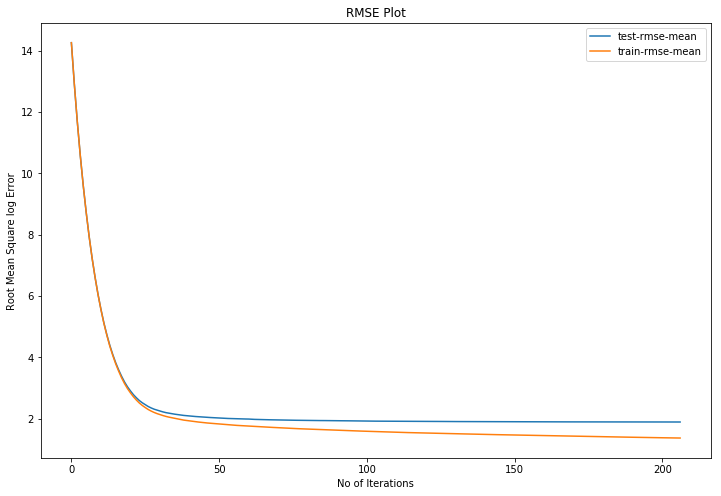

In [76]:
plt.figure(figsize = (12,8))
plt.plot(cv_results.index, cv_results["test-rmse-mean"])
plt.plot(cv_results.index, cv_results["train-rmse-mean"])
plt.legend()
plt.xlabel('No of Iterations')
plt.ylabel('Root Mean Square log Error')
plt.title('RMSE Plot')
plt.show()

## Submission Dataset

In [77]:
kaggle=True
if(kaggle==True):
    if 'revenue' in test_data.columns:
        test_data = test_data.drop(['revenue'],axis=1)
    if 'id' in test_data.columns:
        test_data = test_data.drop(['id'],axis=1)
    dtest = xgb.DMatrix(test_data)
    ypred = xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)
    test_revenue = np.expm1(ypred)
    test['revenue'] = test_revenue
    test[['id','revenue']].to_csv('xgb.csv',index=False)

## Feature Importance
The three factors for measuring feature importance are:

(1) **Weight:** The number of times a feature is used to split the data across all trees.

(2) **Cover:** The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

(3) **Gain:** The average training loss reduction gained when using a feature for splitting.

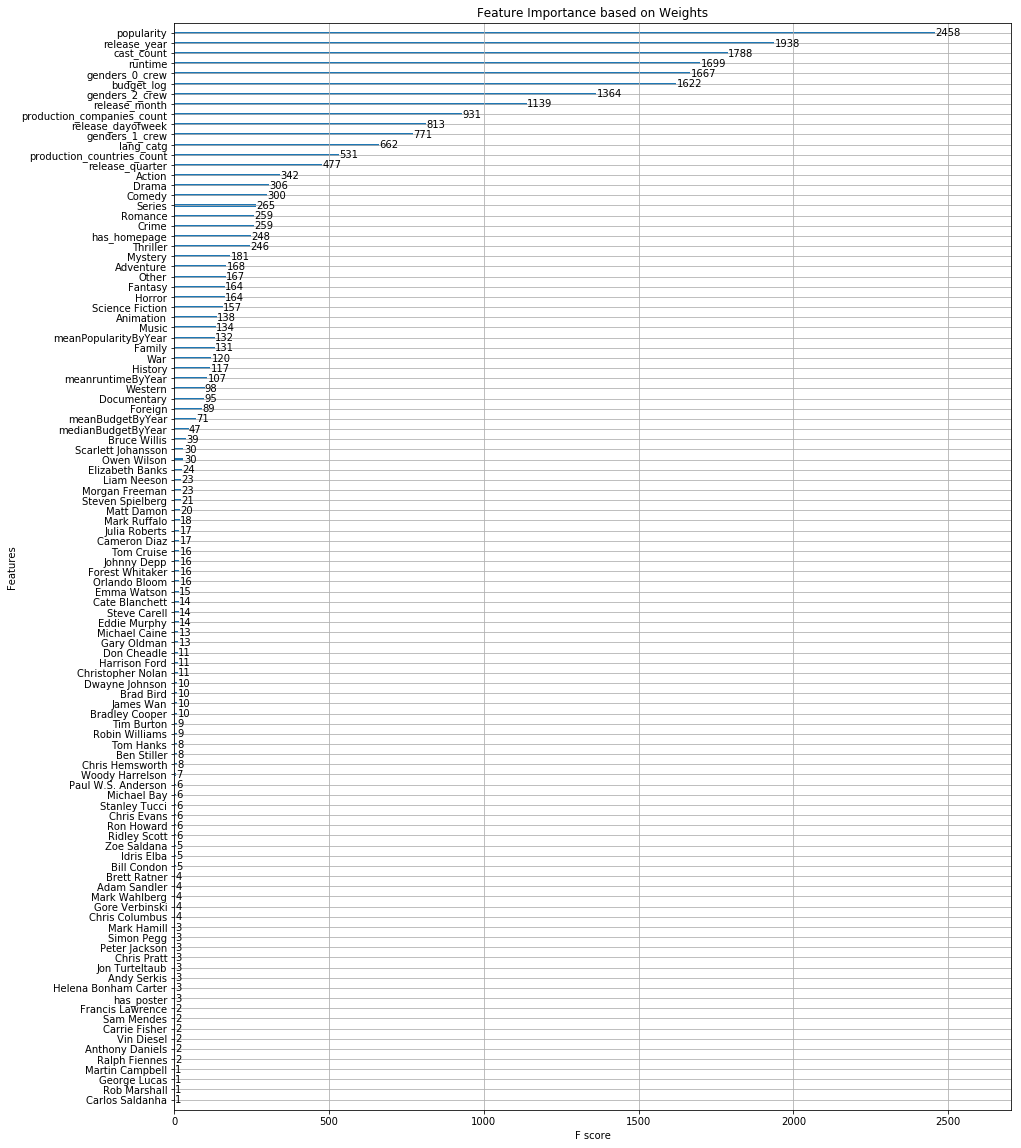

In [78]:
fig, axes = plt.subplots(figsize=(15,20),nrows=1, ncols=1)
xgb.plot_importance(xgb_model, ax=axes, title = 'Feature Importance based on Weights')

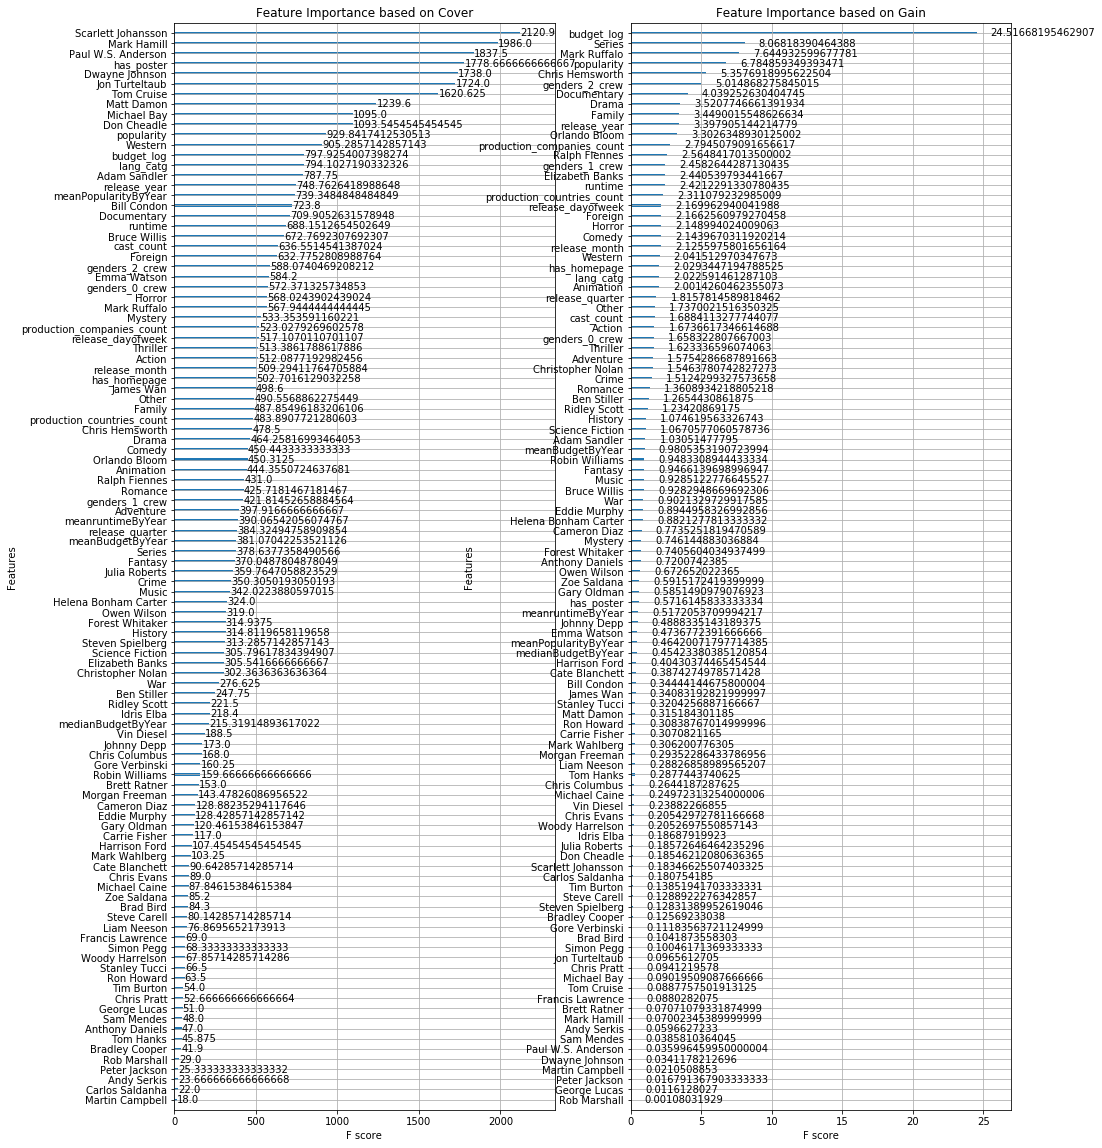

In [79]:
fig, axes = plt.subplots(figsize=(15,20),nrows=1, ncols=2)
xgb.plot_importance(xgb_model, ax=axes[0], importance_type = 'cover', title = 'Feature Importance based on Cover')
xgb.plot_importance(xgb_model, ax=axes[1], importance_type = 'gain', title = 'Feature Importance based on Gain')

### Another way of looking at feature Importance

>SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction

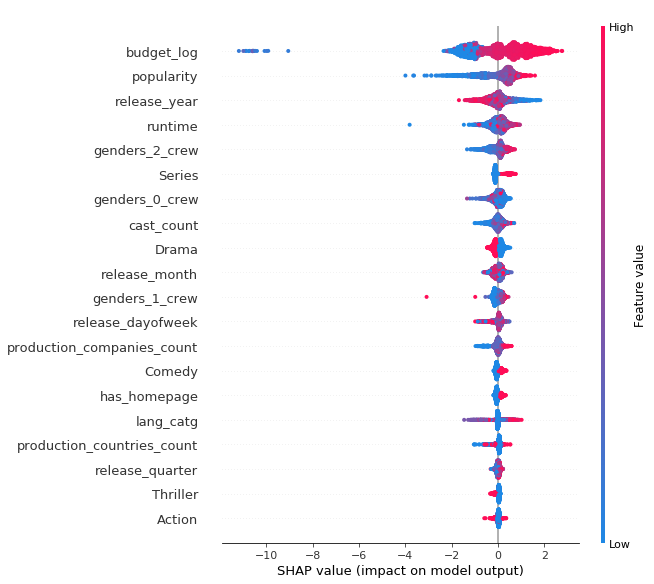

In [80]:
import shap 

shap_values = shap.TreeExplainer(xgb_model).shap_values(train_X) 

shap.summary_plot(shap_values, train_X)

From the above plot we see that Budget and popularity has a greater impact on the revenue of the movie

### Dependency Plots

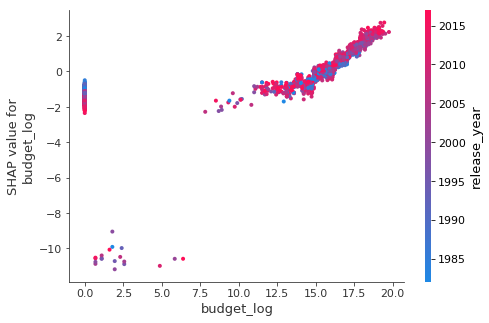

In [81]:
shap.dependence_plot("budget_log", shap_values, train_X)

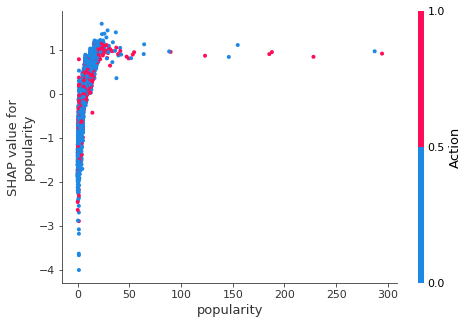

In [82]:
shap.dependence_plot("popularity", shap_values, train_X)

In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb_model).shap_interaction_values(train_X) 

shap.summary_plot(shap_interaction_values, train_X)

### 4. Other Models Considered - CatBoost

In [96]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=100000,
                          learning_rate=0.004,
                          depth=5,
                          eval_metric='RMSE',
                          colsample_bylevel=0.8,
                          random_seed = random_seed,
                          bagging_temperature = 0.2,
                          metric_period = None,
                          early_stopping_rounds=200
                         )
model.fit(x_train, y_train,
          eval_set=(x_dev, y_dev),
          use_best_model=True,
          verbose=False)
    
pred_dev = model.predict(x_dev)
test_pred = model.predict(test_data)
    
test_revenue = np.expm1(test_pred)
test['revenue'] = test_revenue
test[['id','revenue']].to_csv('xgb.csv',index=False)
rms = sqrt(mean_squared_error(y_dev, model.predict(x_dev)))
print (rms)

1.9569994988156185


In [97]:
#Add it to model Result
model_result.loc[len(model_result)]=["Other Model - CatBoost",rms]

## 6. Summary of Results

>Based on the models tried, XGBoost gives the least RMSE of 1.89. 

In [129]:
model_result

,Model Name,RMSE
0,Baseline Regression,2.34487
1,Linear Regression,1.957
2,Neural Network,2.16613
3,XGBoost,1.8948
4,Other Model - CatBoost,1.957


## 7. Conclusions and Future Work